# Assignment 6

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

``Objectives``

* This assignment connects all the pieces involved in training feed-forward fully connected neural networks (FFNN); 

* You will run a full set of experiments to explore different hyperparameters and hidden layer sizes for two datasets, and then document your findings.

``Data``
* Digits MNIST
* Fashion MNIST

### Import libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set_theme(style="darkgrid")  # default style

from keras.datasets import fashion_mnist
from keras.datasets import mnist

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')
# to disbale GPU on my macbook, runs much faster on CPU
tf.config.set_visible_devices([], 'GPU')

2024-06-18 14:47:50.011565: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


---
### Step 1: Data ingestion

In [2]:
# Load the Fashion MNIST dataset.
(X_train_fashion, Y_train_fashion), (X_test_fashion, Y_test_fashion) = fashion_mnist.load_data()

# Load the Digits MNIST dataset.
(X_train_digits, Y_train_digits), (X_test_digits, Y_test_digits) = mnist.load_data()

---
### Step 2: Data preprocessing

``Fashion MNIST``

In [3]:
# Normalize
X_train_fashion = X_train_fashion / 255.
X_test_fashion = X_test_fashion / 255.

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_fashion = Y_train_fashion.flatten()
Y_test_fashion = Y_test_fashion.flatten()

label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_fashion.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_fashion = X_train_fashion[shuffled_indices]
Y_train_fashion = Y_train_fashion[shuffled_indices]

``Digits MNIST``

In [4]:
# Normalize
X_train_digits = X_train_digits / 255
X_test_digits = X_test_digits / 255

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_digits = Y_train_digits.flatten()
Y_test_digits = Y_test_digits.flatten()

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_digits.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_digits = X_train_digits[shuffled_indices]
Y_train_digits = Y_train_digits[shuffled_indices]

---
### Step 3: Exploratory data analysis (EDA)

### <span style="color:chocolate">Exercise 1:</span> Getting to know your data (5 points)

Complete the following task:

1. Show the first training example in X_train_fashion;
2. Show the first training example in X_train_digits;
3. Display the first 5 images in X_train_digits for each class in Y_train_digits, arranged in a 10x5 grid. 

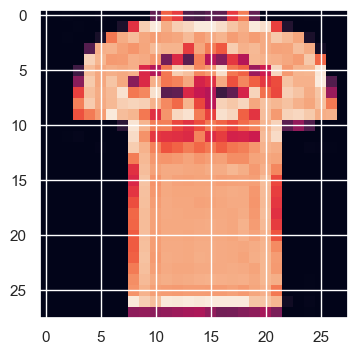

In [5]:
# 1
plt.figure(figsize=(4,4))
plt.imshow(X_train_fashion[0]);

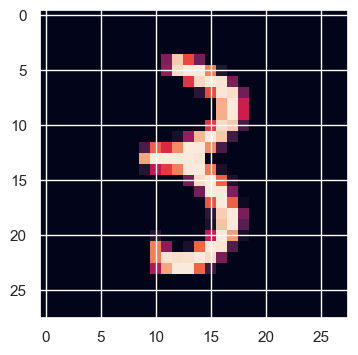

In [6]:
# 2
plt.figure(figsize=(4,4))
plt.imshow(X_train_digits[0])

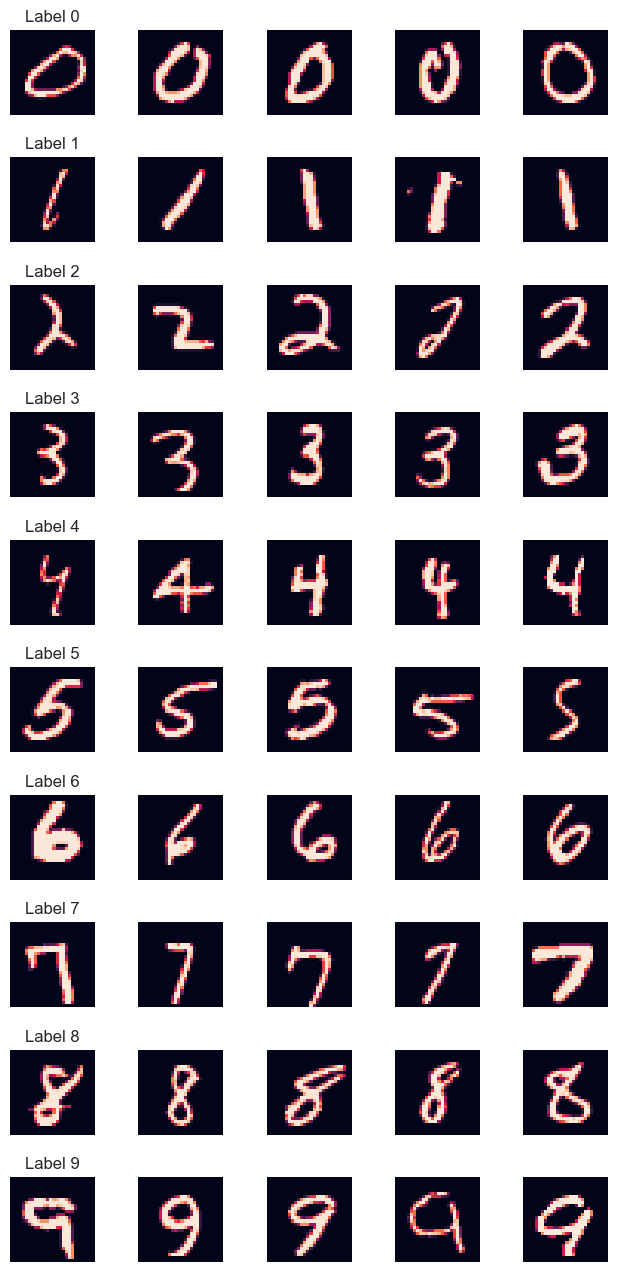

In [7]:
# 3

def print_examples(labels, data, num_rows, num_cols):

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(8, 16))

    # Iterate through each label (each label is one row)
    for row_num in range(10):
        # find the indices of the first 5 images of this label
        image_indices = np.where(labels == row_num)[0][:5]
        
        for col, index in enumerate(image_indices):
            ax = axes[row_num, col]
            ax.imshow(data[index])
            ax.axis('off') 
            if col == 0:
                ax.set_title(f"Label {row_num}") # print the label above the first column of each row

    # Adjust layout and show the plot
    plt.subplots_adjust(hspace=0.5)
    plt.show()

print_examples(labels = Y_train_digits, data = X_train_digits, num_rows = 10, num_cols = 5)

### Step 4: Modeling

### <span style="color:chocolate">Exercise 2:</span> Define model (20 points)

1. Fill in the <span style="color:chocolate">build_model()</span> function below, including all the arguments listed in the function definition. Note: the activation function parameter is only for the the hidden layers; use the appropriate final classification function for the final layer.

In [8]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='tanh',
                optimizer='SGD',
                learning_rate=0.01,
                metric='accuracy'):
    
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.
    metric: The desired metric.

    Returns:
    model: A tf.keras model (graph).
    """

    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # YOUR CODE HERE

    # INPUT layer
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape = (28,28,1), name = 'Input'))
    model.add(tf.keras.layers.Flatten())

    # HIDDEN layers
    for layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(units=layer_size, activation=activation))
    
    # OUTPUT layer
    model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax', name='Output'))

    # Initialize the optimizer
    if optimizer.lower() == 'adam':
        optimizer_instance = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer.lower() == 'sgd':
        optimizer_instance = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")

    # compile the model
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                  optimizer=optimizer_instance,
                  metrics=[metric])

    return model


---
### Step 5: Experiments

You can now run a suite of experiments to see how the hyperparameters and layer sizes effect model performance. 

The <span style="color:chocolate">train_and_evaluate()</span> function below can be used to run experiments and retrieve results.

Training the digits model...


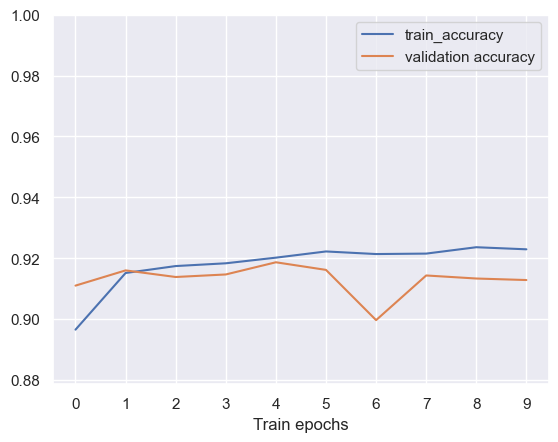

Training accuracy: 0.9229
Validation accuracy: 0.9128


In [9]:
def train_and_evaluate(data = 'digits',
                       hidden_layer_sizes = [],
                       activation = 'tanh',
                       optimizer = 'Adam',
                       learning_rate = 0.01,
                       metric = 'accuracy',
                       num_epochs = 10,
                       verbose = 0):

  # Build the model.
    model = build_model(n_classes = 10,
                      hidden_layer_sizes = hidden_layer_sizes,
                      activation = activation,
                      optimizer = optimizer,
                      metric = metric,
                      learning_rate = learning_rate)

  # Select the dataset.
    if data == 'digits':
        X_train = X_train_digits
        X_test = X_test_digits
        Y_train = Y_train_digits
        Y_test = Y_test_digits
    
    elif data == 'fashion':
        X_train = X_train_fashion
        X_test = X_test_fashion
        Y_train = Y_train_fashion
        Y_test = Y_test_fashion
    else:
        raise 'Unsupported dataset: %s' %data

  # Train the model.
    print('Training the', data, 'model...')
    history = model.fit(x = X_train,
                        y = Y_train,
                        epochs = num_epochs,
                        batch_size = 64,
                        validation_split = 0.1,
                        verbose = verbose)

    # Retrieve the training metrics (after each train epoch) and the final validation
    # accuracy.
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(val_accuracy, label='validation accuracy')
    plt.xticks(range(num_epochs))
    plt.ylim(bottom = min(train_accuracy + val_accuracy) * 0.98, top = 1.)
    plt.xlabel('Train epochs')
    plt.legend()
    plt.show()
    
    print('Training accuracy: %1.4f' %train_accuracy[-1])
    print('Validation accuracy: %1.4f' %val_accuracy[-1])
    
    return model


# run the function
model = train_and_evaluate()

### <span style="color:chocolate">Exercise 3:</span> Ablation study (50 points)

1. Conduct experiments and record the training and validation set accuracy results in the table below. You may extend the table for additional experiments as needed.
2. Report the hyperparameter values for your preferred architecture configuration.
3. Run the model once more using your preferred hyperparameter configuration.

Data | Hidden sizes | Activation| Optimizer | Learning rate | #Parameters | Training accuracy| Validation accuracy
-|-|-|-|-|-|-|-
 digits | [] | tanh | SGD |0.01| 7850 | 0.9001 | 0.9013
 digits | [] | relu | SGD |0.01| 7850 | 0.9002 | 0.9012
 digits | [] | relu | Adam |0.01| 7850 | 0.9230 | 0.9137
 digits | [128] | relu | Adam |0.01| 101770 | 0.9819 | 0.9682
 digits | [256, 128] | relu | Adam |0.01| 235146 | 0.9802 | 0.9702
-|-|-|-|-|-|-|-
 fashion | [] | tanh | SGD |0.01| 7850 | 0.8351 | 0.8202
 fashion | [] | relu | SGD |0.01| 7850 | 0.8391 | 0.8192
 fashion | [] | relu | Adam |0.01| 7850 | 0.8496 | 0.8318
 fashion | [128] | relu | Adam |0.01| 101770 | 0.8792 | 0.8665
 fashion | [256, 128] | relu | Adam |0.01| 235146 | 0.8813 | 0.8678

<span style="color:teal">

MY ANSWERS: 

2) 
my prefered hyperparameters are:
Data | Hidden sizes | Activation| Optimizer | Learning rate | #Parameters | Training accuracy| Validation accuracy
-|-|-|-|-|-|-|-
digits | [256, 128] | relu | Adam |0.01| 235146 | 0.9802 | 0.9702


</span>

Training the digits model...


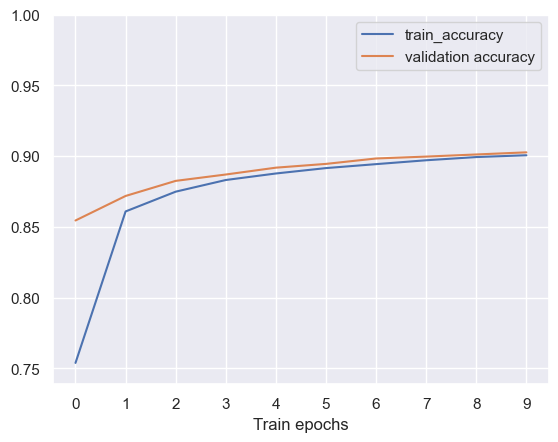

Training accuracy: 0.9006
Validation accuracy: 0.9027


In [10]:
# 1
train_and_evaluate(data = 'digits', hidden_layer_sizes = [], activation = 'tanh', optimizer = 'SGD')

Training the digits model...


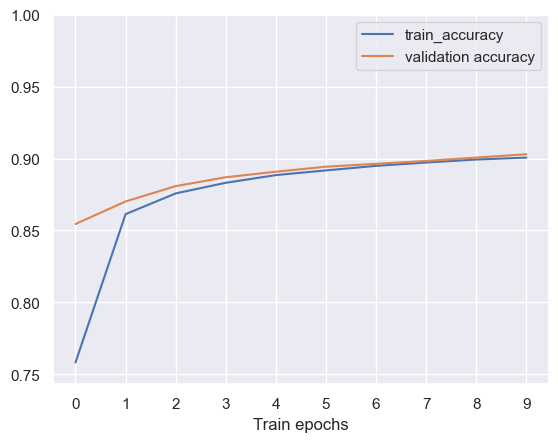

Training accuracy: 0.9006
Validation accuracy: 0.9030


In [11]:
# 2
train_and_evaluate(data = 'digits', hidden_layer_sizes = [], activation = 'relu', optimizer = 'SGD')

Training the digits model...


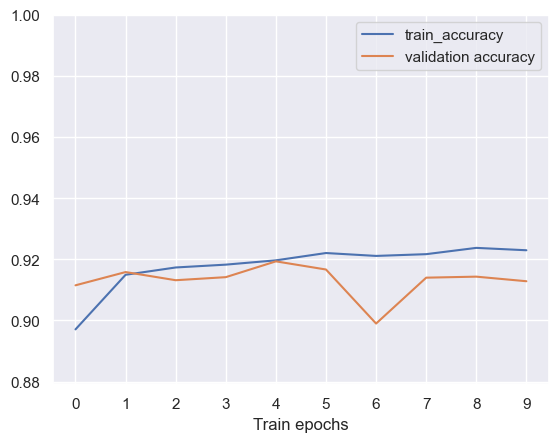

Training accuracy: 0.9230
Validation accuracy: 0.9128


In [12]:
# 3  
train_and_evaluate(data = 'digits', hidden_layer_sizes = [], activation = 'relu', optimizer = 'Adam')

Training the digits model...


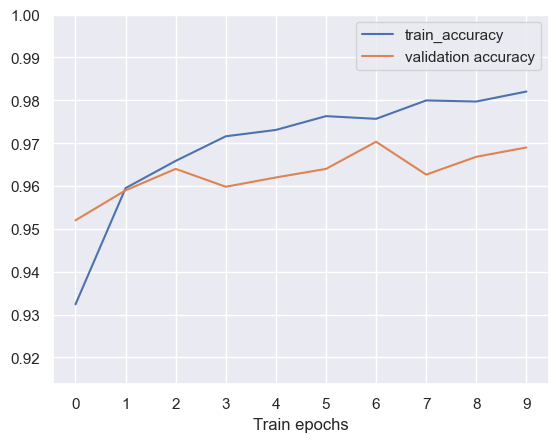

Training accuracy: 0.9821
Validation accuracy: 0.9690


In [13]:
# 4
train_and_evaluate(data = 'digits', hidden_layer_sizes = [128], activation = 'relu', optimizer = 'Adam')

Training the digits model...


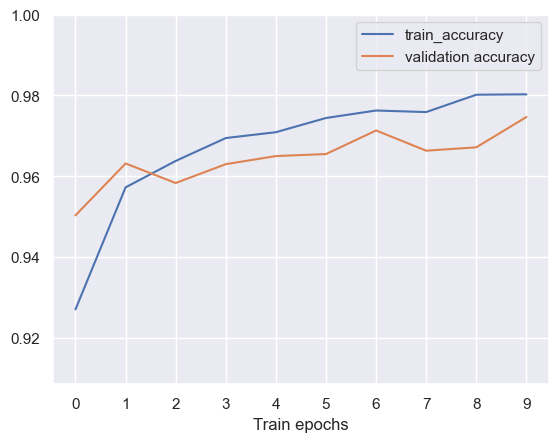

Training accuracy: 0.9803
Validation accuracy: 0.9747


In [14]:
# 5
train_and_evaluate(data = 'digits', hidden_layer_sizes = [256, 128], activation = 'relu', optimizer = 'Adam')

Training the fashion model...


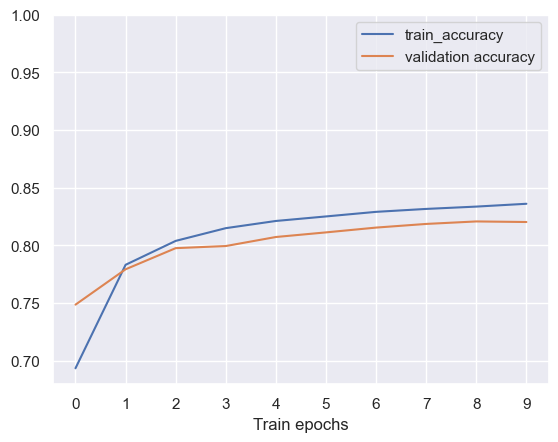

Training accuracy: 0.8360
Validation accuracy: 0.8202


In [15]:
# 6
train_and_evaluate(data = 'fashion', hidden_layer_sizes = [], activation = 'tanh', optimizer = 'SGD')

Training the fashion model...


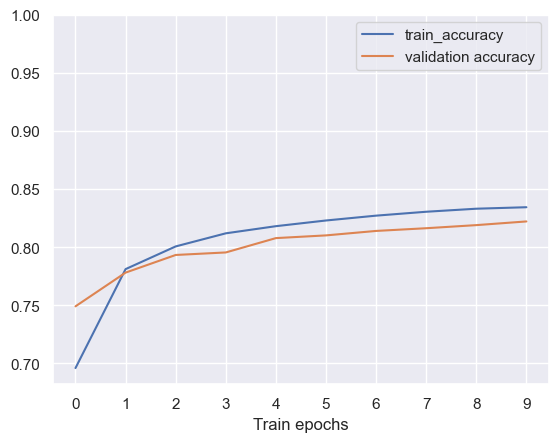

Training accuracy: 0.8344
Validation accuracy: 0.8222


In [16]:
# 7
train_and_evaluate(data = 'fashion', hidden_layer_sizes = [], activation = 'relu', optimizer = 'SGD')

Training the fashion model...


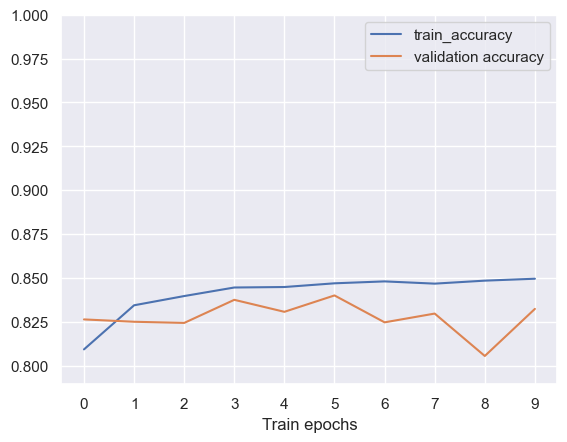

Training accuracy: 0.8495
Validation accuracy: 0.8323


In [17]:
# 8
train_and_evaluate(data = 'fashion', hidden_layer_sizes = [], activation = 'relu', optimizer = 'Adam')

Training the fashion model...


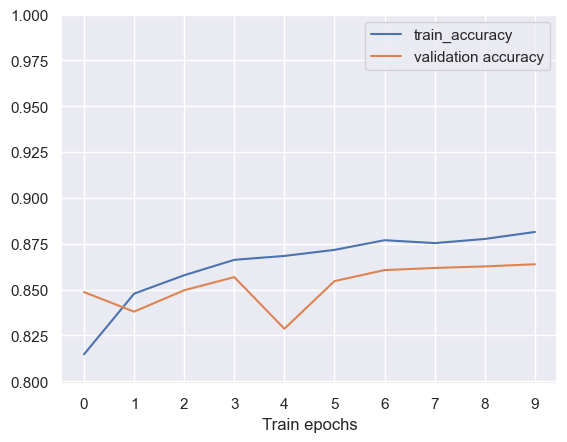

Training accuracy: 0.8815
Validation accuracy: 0.8638


In [18]:
# 9
train_and_evaluate(data = 'fashion', hidden_layer_sizes = [128], activation = 'relu', optimizer = 'Adam')

Training the fashion model...


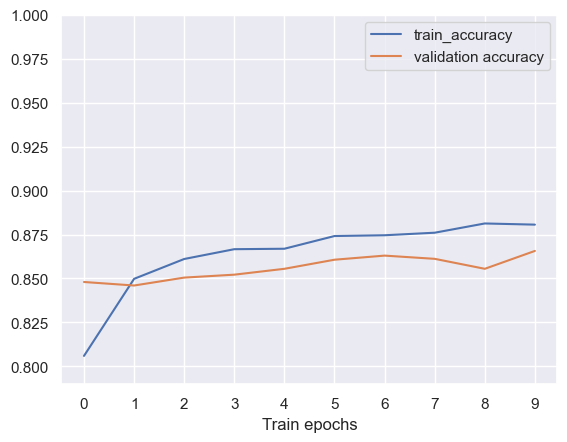

Training accuracy: 0.8806
Validation accuracy: 0.8657


In [19]:
# 10
train_and_evaluate(data = 'fashion', hidden_layer_sizes = [256, 128], activation = 'relu', optimizer = 'Adam')

---
### Step 6: Evaluation and Generalization

### <span style="color:chocolate">Exercise 4:</span> Compute metrics (25 points)

Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

1. Calculate accuracy on both train and test datasets. Note: you will need to convert the vector of predicted probabilities to a class label using the argmax operation. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method provided by tf.keras and the <span style="color:chocolate">np.max()</span> method available in NumPy; or you can use the <span style="color:chocolate">model.evaluare()</span> method provided by tf.keras directly.

2. Does the model demonstrate strong generalization capabilities? Provide an explanation based on your accuracy observations.

Training the digits model...
Epoch 1/10
844/844 [==============================] - 2s 2ms/step - loss: 0.2479 - accuracy: 0.9259 - val_loss: 0.1777 - val_accuracy: 0.9502
Epoch 2/10
844/844 [==============================] - 1s 2ms/step - loss: 0.1510 - accuracy: 0.9571 - val_loss: 0.1584 - val_accuracy: 0.9563
Epoch 3/10
844/844 [==============================] - 1s 2ms/step - loss: 0.1359 - accuracy: 0.9622 - val_loss: 0.1492 - val_accuracy: 0.9600
Epoch 4/10
844/844 [==============================] - 1s 2ms/step - loss: 0.1131 - accuracy: 0.9688 - val_loss: 0.1467 - val_accuracy: 0.9620
Epoch 5/10
844/844 [==============================] - 1s 2ms/step - loss: 0.1026 - accuracy: 0.9726 - val_loss: 0.1121 - val_accuracy: 0.9702
Epoch 6/10
844/844 [==============================] - 1s 2ms/step - loss: 0.0940 - accuracy: 0.9741 - val_loss: 0.1818 - val_accuracy: 0.9583
Epoch 7/10
844/844 [==============================] - 1s 2ms/step - loss: 0.0885 - accuracy: 0.9772 - val_loss: 0.1207 

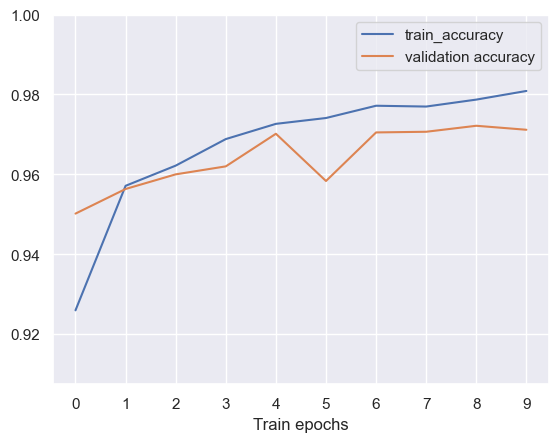

Training accuracy: 0.9809
Validation accuracy: 0.9712
test_accuracy = 0.9706


In [25]:
# YOUR CODE HERE

best_model = train_and_evaluate(data = 'digits', hidden_layer_sizes = [256, 128], activation = 'relu', optimizer = 'Adam', verbose=1)

# Calculate accuracy on test dataset
test_loss, test_accuracy = best_model.evaluate(X_test_digits, Y_test_digits, verbose=0)
print(f'{test_accuracy = :.4f}')

#### my best_model demonstrates very strong generalizaiton ability. Train accuracy of 0.9808 and Test accuracy of 0.9706 is incredibly strong. 